In [6]:
import numpy as np
from scipy import ndimage
import os
import argparse
import cv2
import torch
from collections import OrderedDict
from utils import ACTION_TO_ID, compute_demo_dist, get_prediction_vis, compute_cc_dist
from trainer import Trainer
from demo import Demonstration, load_all_demos

import matplotlib.pyplot as plt
import umap
import umap.plot

%matplotlib inline

In [7]:
# helper function to mix colors
def mix_colors_rgba(color_a, color_b, mode="mix", t=None, gamma=2.2):
    """
    Mix two colors color_a and color_b.

    Arguments:
        color_a:    Real-valued 4-tuple. Foreground color in "blend" mode.
        color_b:    Real-valued 4-tuple. Background color in "blend" mode.
        mode:       "mix":   Interpolate between two colors.
                    "blend": Blend two translucent colors.
        t:          Mixing threshold.
        gamma:      Parameter to control the gamma correction.

    Returns: 
        rgba:       A 4-tuple with the result color.

    To reproduce Markus Jarderot's solution:
            mix_colors_rgba(a, b, mode="blend", t=0, gamma=1.)
    To reproduce Fordi's solution:
            mix_colors_rgba(a, b, mode="mix", t=t, gamma=2.)
    To compute the RGB color of a translucent color on white background:
            mix_colors_rgba(a, [1,1,1,1], mode="blend", t=0, gamma=None)
    """
    assert(mode in ("mix", "blend"))
    assert(gamma is None or gamma>0)
    t = t if t is not None else (0.5 if mode=="mix" else 0.)
    t = max(0,min(t,1))
    color_a = np.asarray(color_a)
    color_b = np.asarray(color_b)
    if mode=="mix" and gamma in (1., None):
        r, g, b, a = (1-t)*color_a + t*color_b
    elif mode=="mix" and gamma > 0:
        r,g,b,_ = np.power((1-t)*color_a**gamma + t*color_b**gamma, 1/gamma)
        a = (1-t)*color_a[-1] + t*color_b[-1]
    elif mode=="blend":
        alpha_a = color_a[-1]*(1-t)
        a = 1 - (1-alpha_a) * (1-color_b[-1])
        s = color_b[-1]*(1-alpha_a)/a
        if gamma in (1., None):
            r, g, b, _ = (1-s)*color_a + s*color_b
        elif gamma > 0:
            r, g, b, _ = np.power((1-s)*color_a**gamma + s*color_b**gamma,
                                  1/gamma)

    return tuple(np.clip([r,g,b,a], 0, 1))

# helper function to blend images
def blend(img1, img2, mask_weight=0.7):
    blended = np.zeros_like(img1)
    img1 = np.concatenate([img1, np.ones([img1.shape[0], img1.shape[1], 1]) * mask_weight], axis=-1)
    img2 = np.concatenate([img2, np.ones([img1.shape[0], img1.shape[1], 1]) * (1-mask_weight)], axis=-1)
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            blended[i, j] = mix_colors_rgba(img1[i, j], img2[i, j], mode='blend')[:-1]
    
    return blended

In [8]:
sim_workspace_limits = np.asarray([[-0.724, -0.276], [-0.224, 0.224], [-0.0001, 0.5]])

stack_snapshot_file = 'logs/base_models/best_stack/snapshot.reinforcement_trial_success_rate_best_value.pth'
row_snapshot_file = 'logs/base_models/best_rows/snapshot.reinforcement_trial_success_rate_best_value.pth'
unstack_snapshot_file = 'logs/base_models/best_unstacking/snapshot.reinforcement_trial_success_rate_best_value.pth'
vertical_square_snapshot_file = 'logs/base_models/vertical_square_hist_densenet/snapshot.reinforcement_trial_success_rate_best_value.pth'

# define trainers
stack_trainer = Trainer(method='reinforcement', push_rewards=True, future_reward_discount=0.5,
                          is_testing=True, snapshot_file=stack_snapshot_file,
                          force_cpu=False, goal_condition_len=0, place=True,
                          pretrained=True, flops=False, network='densenet',
                          common_sense=True, place_common_sense=True,
                          show_heightmap=False, place_dilation=0.05,
                          common_sense_backprop=True, trial_reward='spot',
                          num_dilation=0)

row_trainer = Trainer(method='reinforcement', push_rewards=True, future_reward_discount=0.5,
                          is_testing=True, snapshot_file=row_snapshot_file,
                          force_cpu=False, goal_condition_len=0, place=True,
                          pretrained=True, flops=False, network='densenet',
                          common_sense=True, place_common_sense=True,
                          show_heightmap=False, place_dilation=0.05,
                          common_sense_backprop=True, trial_reward='spot',
                          num_dilation=0)

unstack_trainer = Trainer(method='reinforcement', push_rewards=True, future_reward_discount=0.5,
                          is_testing=True, snapshot_file=unstack_snapshot_file,
                          force_cpu=False, goal_condition_len=0, place=True,
                          pretrained=True, flops=False, network='densenet',
                          common_sense=True, place_common_sense=True,
                          show_heightmap=False, place_dilation=0.05,
                          common_sense_backprop=True, trial_reward='spot',
                          num_dilation=0)

vertical_square_trainer = Trainer(method='reinforcement', push_rewards=True, future_reward_discount=0.5,
                          is_testing=True, snapshot_file=vertical_square_snapshot_file,
                          force_cpu=False, goal_condition_len=0, place=True,
                          pretrained=True, flops=False, network='densenet',
                          common_sense=True, place_common_sense=True,
                          show_heightmap=False, place_dilation=0.05,
                          common_sense_backprop=True, trial_reward='spot',
                          num_dilation=0)

CUDA detected. Running with GPU acceleration.
Pre-trained model snapshot loaded from: logs/base_models/best_stack/snapshot.reinforcement_trial_success_rate_best_value.pth
CUDA detected. Running with GPU acceleration.
Pre-trained model snapshot loaded from: logs/base_models/best_rows/snapshot.reinforcement_trial_success_rate_best_value.pth
CUDA detected. Running with GPU acceleration.
Pre-trained model snapshot loaded from: logs/base_models/best_unstacking/snapshot.reinforcement_trial_success_rate_best_value.pth
CUDA detected. Running with GPU acceleration.
Pre-trained model snapshot loaded from: logs/base_models/vertical_square_hist_densenet/snapshot.reinforcement_trial_success_rate_best_value.pth


In [9]:
img_name = 'stack_place'

demo_color = 'figures/imgs/demo/color/'+ img_name + '.png'
real_color = 'figures/imgs/real/color/' + img_name + '.png'
demo_color = cv2.cvtColor(cv2.imread(demo_color), cv2.COLOR_BGR2RGB)
real_color = cv2.cvtColor(cv2.imread(real_color), cv2.COLOR_BGR2RGB)

demo_depth = 'figures/imgs/demo/depth/' + img_name + '.png'
real_depth = 'figures/imgs/real/depth/' + img_name + '.png'
demo_depth = np.stack([cv2.imread(demo_depth, -1)]*3, axis=-1).astype(np.float32)/100000
real_depth = np.stack([cv2.imread(real_depth, -1)]*3, axis=-1).astype(np.float32)/100000

In [66]:
# define trainer
trainer = unstack_trainer
selected_rot = 1
demo_rot = 10

In [67]:
# run forward passes
demo_push, demo_grasp, demo_place = trainer.forward(demo_color, demo_depth, is_volatile=True, keep_action_feat=True, demo_mask=True)[:3]

# fill masked array (CHANGE IMAGE HERE)
demo_grasp = demo_place.filled(0.0)

# ASSUME ANY IMAGE IS NAMED DEMO GRASP
demo_grasp = np.swapaxes(demo_grasp, 0, 1)

In [68]:
# run forward passes
real_push, real_grasp, real_place = trainer.forward(real_color, real_depth, is_volatile=True, keep_action_feat=True, demo_mask=True)[:3]

# fill masked array (CHANGE IMAGE HERE)
real_grasp = real_place.filled(0.0)

# ASSUME ANY IMAGE IS NAMED REAL GRASP
real_grasp = np.swapaxes(real_grasp, 0, 1)

# get masked inds
real_mask = (real_grasp == 0).all(axis=0).astype(int)
demo_mask = (demo_grasp == 0).all(axis=0).astype(int)

In [69]:
# flatten real_grasp
real_grasp_flat = real_grasp.reshape(64, -1).T

# apply mask
real_grasp_flat_masked = real_grasp_flat[real_mask.flatten() == 0]

# flatten demo_grasp
demo_grasp_flat = demo_grasp.reshape(64, -1).T

# apply mask
demo_grasp_flat_masked = demo_grasp_flat[demo_mask.flatten() == 0]

print(real_grasp_flat_masked.shape, demo_grasp_flat_masked.shape)

fit = umap.UMAP(n_components=3, n_neighbors=5)
grasp_colorized = fit.fit_transform(np.concatenate([demo_grasp_flat_masked, real_grasp_flat_masked]))

#umap.plot.points(fit)

(236304, 64) (87552, 64)


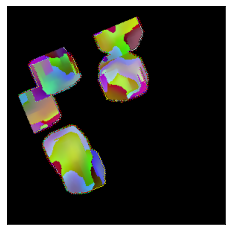

In [70]:
# to colorize, take 3D value and convert to an rgb color
#grasp_colorized_norm = np.linalg.norm(grasp_colorized, axis=1)

# split into real and demo
demo_colorized = grasp_colorized[:demo_grasp_flat_masked.shape[0]]
real_colorized = grasp_colorized[demo_grasp_flat_masked.shape[0]:]

# set unmasked values to colors
real_flat_colorized = np.stack([real_grasp.copy()[0, ...].flatten()]*3, axis=-1)
real_flat_colorized[real_mask.flatten() == 0] = real_colorized
real_flat_colorized[real_mask.flatten() != 0] = (0, 0, 0)

# reshape to get colorized img (index into rotation 0)
real_colorized_img = real_flat_colorized.reshape(16, 224, 224, 3)

# add circle around selected action
fig, ax = plt.subplots(1)
ax.set_aspect('equal')

# set table mask depending on which mask we are using
table_mask = real_mask

# blend orig img and colorized embedding
#gray_mask = np.stack([real_colorized_img[2] * 255/np.max(real_colorized_img[2])]*3, axis=-1).astype(np.uint8)
#color_mask = cv2.applyColorMap(gray_mask, cv2.COLORMAP_JET)
#color_mask[table_mask[0] != 0] = 0
color_mask = (real_colorized_img / np.max(real_colorized_img, axis=(0, 1, 2), keepdims=True)) * 255

# rotate img
rotated_color = ndimage.rotate(real_depth, 22.5 * selected_rot).astype(np.uint8)
rotated_mask = ndimage.rotate(color_mask[selected_rot], 22.5 * selected_rot).astype(np.uint8)
crop_start_ind = int(np.rint((rotated_color.shape[0] - 224) / 2))
#rotated_color = rotated_color[crop_start_ind:crop_start_ind+224, crop_start_ind:crop_start_ind+224]
#rotated_mask = rotated_mask[crop_start_ind:crop_start_ind+224, crop_start_ind:crop_start_ind+224]
#final_img = cv2.addWeighted(rotated_color, 0.45, rotated_mask, 0.55, 0)
final_img = blend(rotated_mask/255, rotated_color / 255, mask_weight=0.7)

ax.imshow(final_img)
#circ = Circle((23, 72), 10, linewidth=3, color=(1, 0, 0, 1), fill=False)
#ax.add_patch(circ)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    right=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False,

    labelleft=False) # labels along the bottom edge are off

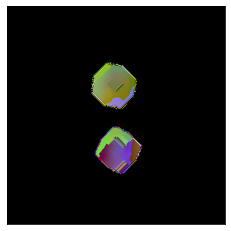

In [71]:
# viz demo img

# set unmasked values to colors
demo_flat_colorized = np.stack([demo_grasp.copy()[0, ...].flatten()]*3, axis=-1)
demo_flat_colorized[demo_mask.flatten() == 0] = demo_colorized
demo_flat_colorized[demo_mask.flatten() != 0] = (0, 0, 0)

# reshape to get colorized img
demo_colorized_img = demo_flat_colorized.reshape(16, 224, 224, 3)

# add circle around selected action
fig, ax = plt.subplots(1)
ax.set_aspect('equal')

# set table mask depending on which mask we are using
table_mask = demo_mask

# get color mask
color_mask = (demo_colorized_img / np.max(demo_colorized_img, axis=(0, 1, 2), keepdims=True)) * 255

# rotate img
rotated_color = ndimage.rotate(demo_depth, 22.5 * demo_rot).astype(np.uint8)
rotated_mask = ndimage.rotate(color_mask[demo_rot], 22.5 * demo_rot).astype(np.uint8)
crop_start_ind = int(np.rint((rotated_color.shape[0] - 224) / 2))
#rotated_color = rotated_color[crop_start_ind:crop_start_ind+224, crop_start_ind:crop_start_ind+224]
#rotated_mask = rotated_mask[crop_start_ind:crop_start_ind+224, crop_start_ind:crop_start_ind+224]
#final_img = cv2.addWeighted(rotated_color, 0.45, rotated_mask, 0.55, 0)
final_img = blend(rotated_mask/255, rotated_color / 255, mask_weight=0.6)
ax.imshow(final_img)
#circ = Circle((23, 72), 10, linewidth=3, color=(1, 0, 0, 1), fill=False)
#ax.add_patch(circ)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    right=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False,

    labelleft=False) # labels along the bottom edge are off

## Visualizing Q-Values

(42, 7, 71, 136)


error: OpenCV(4.4.0) /tmp/pip-req-build-6179nsls/opencv/modules/imgproc/src/colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'operator()'


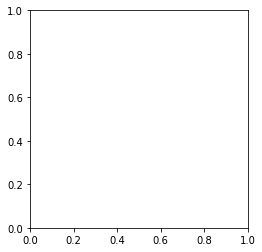

In [402]:
from matplotlib.patches import Circle
#real_grasp_img = np.swapaxes(real_grasp[:, :, :], 1, 2)
real_grasp_img = real_grasp
best_pix_ind = np.unravel_index(np.argmax(real_grasp_img), real_grasp_img.shape)
print(best_pix_ind)

real_grasp_img_norm = real_grasp_img - np.min(real_grasp_img)
real_grasp_img_norm *= 255 / np.max(real_grasp_img_norm)
real_grasp_img_norm = real_grasp_img_norm.astype(np.uint8)

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

circ = Circle((best_pix_ind[2],best_pix_ind[1]), 10, linewidth=3, color=(0, 0, 1, 1), fill=False)

# generate colormap
color_mask = cv2.applyColorMap(real_grasp_img_norm[best_pix_ind[0]], cv2.COLORMAP_JET)

# rotate img and mask
rotated_color = ndimage.rotate(real_color, 22.5 * 4).astype(np.uint8)
rotated_mask = ndimage.rotate(color_mask, 22.5 * 4).astype(np.uint8)
#crop_start_ind = int(np.rint((rotated_color.shape[0] - 224) / 2))
#rotated_color = rotated_color[crop_start_ind:crop_start_ind+224, crop_start_ind:crop_start_ind+224]
#rotated_mask = rotated_mask[crop_start_ind:crop_start_ind+224, crop_start_ind:crop_start_ind+224]

print(rotated_color.shape, rotated_mask.shape)

#final_img = blend(real_color / 255, color_mask / 255)
final_img = cv2.addWeighted(rotated_color, 0.4, rotated_mask, 0.6, 0)

ax.imshow(final_img, cmap='jet')

ax.add_patch(circ)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    right=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

## Compute SSR matched action

In [49]:
# get all demo embeddings
_, _, demo_row = row_trainer.forward(demo_color, demo_depth, is_volatile=True, keep_action_feat=True, demo_mask=True)[:3]
_, _, demo_unstack = unstack_trainer.forward(demo_color, demo_depth, is_volatile=True, keep_action_feat=True, demo_mask=True)[:3]
_, _, demo_vertical_square = vertical_square_trainer.forward(demo_color, demo_depth, is_volatile=True, keep_action_feat=True, demo_mask=True)[:3]

# get all real embeddings
_, _, real_row = row_trainer.forward(real_color, real_depth, is_volatile=True, keep_action_feat=True, demo_mask=True)[:3]
_, _, real_unstack = unstack_trainer.forward(real_color, real_depth, is_volatile=True, keep_action_feat=True, demo_mask=True)[:3]
_, _, real_vertical_square = vertical_square_trainer.forward(real_color, real_depth, is_volatile=True, keep_action_feat=True, demo_mask=True)[:3]

In [50]:
# fill masked arrays
demo_row = demo_row.filled(0.0)
demo_unstack = demo_unstack.filled(0.0)
demo_vertical_square = demo_vertical_square.filled(0.0)

real_row = real_row.filled(0.0)
real_unstack = real_unstack.filled(0.0)
real_vertical_square = real_vertical_square.filled(0.0)

In [51]:
# get masks for demo and real
demo_mask = np.all((demo_row == 0), axis=1)
real_mask = np.all((real_row == 0), axis=1)

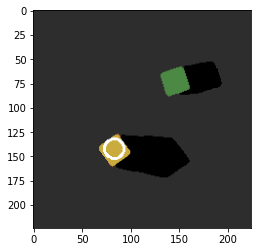

In [52]:
# index into demo action
demo_action_ind = [10, 142, 83]
demo_color_viz = demo_color.copy()
cv2.circle(demo_color_viz, (demo_action_ind[2], demo_action_ind[1]), 10, color=(255, 255, 255), thickness=2)
plt.imshow(demo_color_viz)

# index into demo to get best action
demo_row_action = demo_row[demo_action_ind[0], :, demo_action_ind[1], demo_action_ind[2]]
demo_unstack_action = demo_unstack[demo_action_ind[0], :, demo_action_ind[1], demo_action_ind[2]]
demo_vertical_square_action = demo_vertical_square[demo_action_ind[0], :, demo_action_ind[1], demo_action_ind[2]]

In [64]:
# match
row_dist = np.sum(np.square(real_row - np.expand_dims(demo_row_action, (0, 2, 3))), axis=1)
unstack_dist = np.sum(np.square(real_unstack - np.expand_dims(demo_unstack_action, (0, 2, 3))), axis=1)
vertical_square_dist = np.sum(np.square(real_vertical_square - np.expand_dims(demo_vertical_square_action, (0, 2, 3))), axis=1)

# make masked spot dists inf
row_dist[real_mask] = np.max(row_dist) * 1.1
unstack_dist[real_mask] = np.max(unstack_dist) * 1.1
vertical_square_dist[real_mask] = np.max(vertical_square_dist) * 1.1

row_match = np.unravel_index(np.argmin(row_dist), row_dist.shape)
unstack_match = np.unravel_index(np.argmin(unstack_dist), unstack_dist.shape)
vertical_square_match = np.unravel_index(np.argmin(vertical_square_dist), vertical_square_dist.shape)

print(np.argmin([np.min(row_dist), np.min(unstack_dist), np.min(vertical_square_dist)]))
matched_action = np.unravel_index(np.argmin(unstack_dist), unstack_dist.shape)

print('row rot', row_match[0], 'unstack rot', unstack_match[0], 'square rot', vertical_square_match[0])

2
row rot 7 unstack rot 1 square rot 8


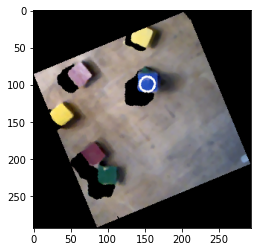

In [65]:
# viz
fig, ax = plt.subplots(1)
ax.set_aspect('equal')

# add circle to img
real_color_viz = real_color.copy()
cv2.circle(real_color_viz, (matched_action[2], matched_action[1]), 10, color=(255, 255, 255), thickness=2)

# rotate img
real_color_viz = ndimage.rotate(real_color_viz, 22.5 * matched_action[0])


#circ = Circle((matched_action[2], matched_action[1]), 10, linewidth=3, color=(1, 1, 1, 1), fill=False)
#ax.add_patch(circ)

ax.imshow(real_color_viz)

In [38]:
# index into real embeds to get best action embeds
real_row_action = real_row[row_match[0], :, row_match[1], row_match[2]]
real_unstack_action = real_unstack[unstack_match[0], :, unstack_match[1], unstack_match[2]]
real_vertical_square_action = real_vertical_square[vertical_square_match[0], :, vertical_square_match[1], vertical_square_match[2]]

# compute rematch
row_dist = np.sum(np.square(demo_row - np.expand_dims(real_row_action, (0, 2, 3))), axis=1)
unstack_dist = np.sum(np.square(demo_unstack - np.expand_dims(real_unstack_action, (0, 2, 3))), axis=1)
vertical_square_dist = np.sum(np.square(demo_vertical_square - np.expand_dims(real_vertical_square_action, (0, 2, 3))), axis=1)

# make masked spot dists inf
row_dist[demo_mask] = np.max(row_dist) * 1.1
unstack_dist[demo_mask] = np.max(unstack_dist) * 1.1
vertical_square_dist[demo_mask] = np.max(vertical_square_dist) * 1.1

# rematch inds
row_rematch = np.array(np.unravel_index(np.argmin(row_dist), row_dist.shape))
unstack_rematch = np.array(np.unravel_index(np.argmin(unstack_dist), unstack_dist.shape))
vertical_square_rematch = np.array(np.unravel_index(np.argmin(vertical_square_dist), vertical_square_dist.shape))

In [63]:
print('row dist:', np.linalg.norm(row_rematch[1:] - row_match[1:]))
print('unstack dist:', np.linalg.norm(unstack_rematch[1:] - unstack_match[1:]))
print('vertical square dist:', np.linalg.norm(vertical_square_rematch[1:] - vertical_square_match[1:]))

row dist: 93.50935782048768
unstack dist: 80.43009387039157
vertical square dist: 101.41498903022176


In [39]:
print(unstack_match)

(12, 71, 138)


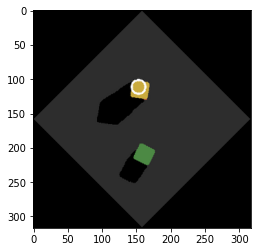

In [62]:
# viz rematches
# viz
fig, ax = plt.subplots(1)
ax.set_aspect('equal')

# add circle to img
real_color_viz = demo_color.copy()
cv2.circle(real_color_viz, (vertical_square_rematch[2], vertical_square_rematch[1]), 10, color=(255, 255, 255), thickness=2)

# rotate img
real_color_viz = ndimage.rotate(real_color_viz, 22.5 * demo_rot)


#circ = Circle((matched_action[2], matched_action[1]), 10, linewidth=3, color=(1, 1, 1, 1), fill=False)
#ax.add_patch(circ)

ax.imshow(real_color_viz)